# HDDA F24 Recommendation systems via approximate matrix factorization

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 1


In [236]:
from typing import Callable, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import torch
import tqdm
from scipy.sparse import csr_matrix
from sklearn.impute import SimpleImputer

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

## Utilities


In [237]:
def get_params_combinations(params: list[list]):
    if len(params) == 0:
        return [[]]
    return [(x, *k) for k in get_params_combinations(params[1:]) for x in params[0]]


def get_params_combinations_dict(possible_params_dict: dict[str, list]):
    if len(possible_params_dict) == 0:
        return [{}]
    dict_items = list(possible_params_dict.items())

    first_item = dict_items[0]

    if not isinstance(first_item[1], list):
        return [
            {first_item[0]: first_item[1], **k}
            for k in get_params_combinations_dict(dict(dict_items[1:]))
        ]

    return [
        {first_item[0]: x, **k}
        for k in get_params_combinations_dict(dict(dict_items[1:]))
        for x in first_item[1]
    ]

In [238]:
def rmse_score(
    initial_matrix: torch.tensor, predicted_matrix: torch.tensor, test_mask: torch.tensor
) -> float:
    differences = (initial_matrix[test_mask] - predicted_matrix[test_mask]) ** 2
    return torch.sqrt(differences.mean()).item()

In [239]:
def choose_best(
    matrix: torch.tensor,
    mask: torch.tensor,
    solver: Callable,
    possible_params: dict,
    loss_param: str = "rmse",
) -> tuple[torch.tensor, float, dict, dict]:
    best_loss = 1e3
    best_solution = np.zeros(1)
    best_params = {}

    log_dicts = {}

    for params in get_params_combinations_dict(possible_params):
        solution, log_dict = solver(matrix, mask, **params)
        log_dicts[str(params)] = log_dict

        loss = log_dict[loss_param][-1]

        if loss < best_loss:
            best_loss = loss
            best_solution = solution.clone()
            best_params = params.copy()

    return best_solution, best_loss, best_params, log_dicts

In [240]:
def plot_log_dicts(log_dicts: dict, title: str):
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(5 * 2, 7 * 1),
    )
    axs_list = list(axs.flat)

    for ax in axs_list:
        ax.grid()

    axs[0].set(xlabel="Iteration", ylabel="Objective, log")
    axs[1].set(xlabel="Iteration", ylabel="RMSE, log")
    axs[0].set_yscale("log")
    axs[1].set_yscale("log")

    for idx, (name, log_dict) in enumerate(log_dicts.items()):
        axs[0].plot(log_dict["iteration"], log_dict["objective"], label=idx)
        axs[1].plot(log_dict["iteration"], log_dict["rmse"], label=idx)

    fig.suptitle(title, fontsize=14)

    lines_labels = [axs_list[0].get_legend_handles_labels()]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]

    fig.legend(
        lines,
        labels,
        loc="outside lower center",
        bbox_to_anchor=(0.5, -0.05),
    )
    plt.tight_layout()
    plt.show()

## Data loading


### Toy data


In [241]:
toy_matrix = (
    torch.tensor(
        [
            [2, 3, 2, 0, 0],
            [0, 2, 0, 4, 3],
            [3, 0, 3, 0, 4],
            [0, 3, 0, 4, 3],
            [0, 0, 0, 0, 2],
            [1, 4, 3, 4, 0],
        ]
    )
    .float()
    .to(DEVICE)
)  # 0  for unknown

toy_mask = toy_matrix != 0

### Real data


In [242]:
def load_real_data() -> tuple[torch.tensor, torch.tensor]:
    data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
    x = csr_matrix(data["X"]).toarray()
    mask = x != 0
    return torch.tensor(x).float().to(DEVICE), torch.tensor(mask).to(DEVICE)


real_matrix, real_mask = load_real_data()

## Test real data


In [243]:
def load_real_test_flatten_indices(real_matrix_shape: tuple) -> torch.tensor:
    data = scipy.io.loadmat("./data/Data/matlab/inputEval.mat")
    x = data["Eval"]
    rows_indices = x[:, 0].astype(np.float64) - 1
    columns_indices = x[:, 1].astype(np.float64) - 1
    return (
        torch.tensor(rows_indices * real_matrix_shape[1] + columns_indices)
        .int()
        .to(DEVICE)
    )


real_test_flatten_indices = load_real_test_flatten_indices(real_matrix.shape)
real_test_flatten_indices

tensor([     593,     3104,     1544,  ..., 23868889, 23868137, 23868149],
       device='cuda:0', dtype=torch.int32)

In [244]:
def save_solution(
    matrix: torch.tensor,
    test_flatten_indices: torch.tensor = real_test_flatten_indices,
    prefix: str = "",
    decimals: int = 4,
):
    predictions = np.round(
        matrix.flatten()[test_flatten_indices].cpu().numpy(), decimals=decimals
    )
    results = pd.DataFrame(
        predictions, columns=["Rating"], index=np.arange(1, predictions.shape[0] + 1)
    )
    results.to_csv(f"./solutions/{prefix}submission.csv", index_label="ID")

## Block coordinate descent


In [245]:
class Optimizer:
    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        raise NotImplementedError

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        raise NotImplementedError


class GradientDescent(Optimizer):
    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        return -grad

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, *args
    ) -> torch.tensor:
        return x - lr * grad


class Nesterov(Optimizer):
    def __init__(self, beta: float = 0.99):
        self.beta = beta

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        h = grad.clone() if k == 0 else self.beta * self.h_prev + grad
        return -(grad + self.beta * h)

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        if k == 0:
            self.h = grad.clone()
        else:
            self.h = self.beta * self.h_prev + grad
        g = grad + self.beta * self.h
        self.h_prev = self.h.clone()
        return x - lr * g


class AdaGrad(Optimizer):
    def __init__(
        self,
        eps=1e-10,
        lr_decay: float = 0,
    ):
        self.lr_decay = lr_decay
        self.eps = eps
        self.state_sum = None

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        if self.state_sum is None:
            state_sum = torch.zeros_like(grad)
        else:
            state_sum = self.state_sum.clone()
        state_sum += grad**2

        return -grad / torch.sqrt(state_sum + self.eps)

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        gamma = lr / (1 + k * self.lr_decay)
        if self.state_sum is None:
            self.state_sum = torch.zeros_like(grad)

        self.state_sum += grad**2

        return x - gamma * grad / torch.sqrt(self.state_sum + self.eps)


class RMSprop(Optimizer):
    def __init__(
        self,
        eps=1e-10,
        alpha=0.99,
    ):
        self.alpha = alpha
        self.eps = eps

        self.exp_avg_sq = None

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        if self.exp_avg_sq is None:
            exp_avg_sq = torch.zeros_like(x)
        else:
            exp_avg_sq = self.exp_avg_sq.copy()

        exp_avg_sq.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)

        return -grad / torch.sqrt(exp_avg_sq + self.eps)

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        if self.exp_avg_sq is None:
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg_sq.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)

        return x - lr * grad / torch.sqrt(self.exp_avg_sq + self.eps)


class Adam(Optimizer):
    def __init__(
        self,
        betas: tuple[float, float] = (0.9, 0.999),
        eps=1e-10,
        weight_decay: float = 1e-2,
    ):
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.exp_avg = None
        self.exp_avg_sq = None

    def get_direction(self, x: torch.tensor, grad: torch.tensor, k: int) -> torch.tensor:
        step_k = k + 1
        beta1, beta2 = self.betas

        exp_avg = (
            self.exp_avg.clone() if self.exp_avg is not None else torch.zeros_like(x)
        )
        exp_avg_sq = (
            self.exp_avg_sq.clone()
            if self.exp_avg_sq is not None
            else torch.zeros_like(x)
        )

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        bias_correction1 = 1 - beta1**step_k
        bias_correction2 = 1 - beta2**step_k

        denom = exp_avg_sq.div(bias_correction2).sqrt_().add_(self.eps)

        return -torch.div(exp_avg, bias_correction1).div_(denom) - self.weight_decay * x

    def step(
        self, x: torch.tensor, grad: torch.tensor, lr: float, k: int, grad_f
    ) -> torch.tensor:
        step_k = k + 1

        beta1, beta2 = self.betas
        if self.exp_avg is None or self.exp_avg_sq is None:
            self.exp_avg = torch.zeros_like(x)
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        self.exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        bias_correction1 = 1 - beta1**step_k
        bias_correction2 = 1 - beta2**step_k

        denom = self.exp_avg_sq.div(bias_correction2).sqrt_().add_(self.eps)

        return (
            x
            - lr * torch.div(self.exp_avg, bias_correction1).div_(denom)
            - lr * self.weight_decay * x
        )

In [246]:
def estimate_1overL(
    x: torch.tensor,
    grad: torch.tensor,
    f,
    direction: torch.tensor,
    beta: float = 0.25,
    iters: int = 100,
    eps: float = 1e-7,
):
    alpha = 1

    i = 0
    while True:
        x_next = x + alpha * direction
        if f(x_next) > eps + f(x) + torch.trace(grad.T @ (x_next - x)) + torch.norm(
            x_next - x, p="fro"
        ) ** 2 / (2 * alpha):
            i += 1
            alpha *= beta
            if alpha < 1e-10:
                return alpha

        else:
            return alpha

        if i >= iters:
            return alpha


def adaptive_step(
    x: torch.tensor,
    prev_x: torch.tensor,
    grad: torch.tensor,
    prev_grad: torch.tensor,
    prev_step,
    theta,
    start_step: float = 1e-10,
):
    if prev_step is None:
        step = start_step
        theta = np.inf
        return step, theta

    step = prev_step
    if torch.norm(prev_grad - grad) < 1e-5:
        min_value = np.sqrt(1 + theta) * step
    else:
        min_value = min(
            np.sqrt(1 + theta) * step,
            torch.norm(x - prev_x).cpu().numpy()
            / (2 * torch.norm(prev_grad - grad).cpu().numpy()),
        )

    if min_value == np.inf:
        min_value = 0.001

    theta = min_value / step
    step = min_value
    return step, theta


def armijo(
    x,
    grad,
    f,
    direction: torch.tensor,
    c1: float = 1e-6,
    beta: float = 0.5,
    iters: int = 50,
    alpha_init: float = 1,
):
    alpha = alpha_init

    d_g = torch.trace(grad.T @ direction).item()
    f_x = f(x)

    # print((f(x + alpha * direction) - f_x) / (alpha * d_g))

    i = 0
    while f(x + alpha * direction) > f_x + c1 * alpha * d_g:
        i += 1

        if i == iters:
            return alpha

        if alpha < 1e-7:
            return alpha

        alpha = alpha * beta

    return alpha


def bisection_weak_wolfe(
    x,
    grad,
    grad_f,
    f,
    direction: torch.tensor,
    c1: float = 1e-5,
    c2: float = 0.9,
    alpha_init: float = 1.0,
    iters: int = 100,
):
    alpha = alpha_init
    lb = 0
    ub = np.inf

    d_g = torch.trace(grad.T @ direction)

    i = 0
    while True:
        i += 1
        if f(x + alpha * direction) > f(x) + c1 * alpha * d_g:
            ub = alpha
            alpha = 0.5 * (lb + ub)
        elif torch.trace(grad_f(x + alpha * direction).T @ direction) < c2 * d_g:
            lb = alpha
            alpha = 2 * lb if np.isinf(ub) else 0.5 * (lb + ub)
        else:
            break
        if alpha < 1e-16:
            return alpha
        if i > iters:
            break
    return alpha

In [247]:
def pred(u: torch.tensor, v: torch.tensor) -> torch.tensor:
    return torch.clip(u @ v, 1, 5)


def init_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    rank: int,
    strategy: Literal["random", "svd", "mean"],
) -> tuple[torch.tensor, torch.tensor]:
    m, n = matrix.shape
    new_matrix = matrix.cpu().numpy()

    if strategy == "random":
        return torch.rand(m, rank).to(DEVICE), torch.rand(rank, n).to(DEVICE)

    if strategy == "mean":
        new_matrix = SimpleImputer(
            strategy=strategy, missing_values=0, keep_empty_features=True
        ).fit_transform(new_matrix)

    u, s, vt = sklearn.utils.extmath.randomized_svd(
        new_matrix, n_iter=25, n_components=rank
    )
    v = vt

    return torch.tensor(u).float().to(DEVICE), torch.tensor(v).float().to(DEVICE)


def objective_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    u: torch.tensor,
    v: torch.tensor,
    regularization: float = 0.0,
) -> float:
    return (
        torch.norm(mask * torch.pow((matrix - (u @ v)), 2), p="fro")
        + regularization * (torch.norm(u, p="fro") ** 2 + torch.norm(v, p="fro") ** 2)
    ).item()


def nabla_objective_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    u: torch.tensor,
    v: torch.tensor,
    for_v: bool = False,
    regularization: float = 0.0,
) -> torch.tensor:
    if for_v:
        return (
            -2 * u.T @ (mask * matrix)
            + 2 * u.T @ (mask * (u @ v))
            + regularization * 2 * v
        )

    return (
        -2 * (mask * matrix) @ v.T + 2 * (mask * (u @ v)) @ v.T + regularization * 2 * u
    )


def block_gd(
    matrix: torch.tensor,
    mask: torch.tensor,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    lr_strategy: Literal[
        "normal",
        "adaptive",
        "bisection",
        "armijo_rule",
        "1/L",
    ] = "normal",
    verbose: bool = True,
    seed: int = 420,
) -> tuple[torch.tensor, dict]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy)

    log_dict = {
        "objective": [],
        "rmse": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    # For adaprive
    stepu = None
    stepv = None

    thetau = 0
    thetav = 0

    prev_grad_u = 0
    prev_grad_v = 0

    prev_u = u.clone()
    prev_v = v.clone()

    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            if lr_strategy == "adaptive":
                # Adaptive step
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                stepu, thetau = adaptive_step(
                    u, prev_u, grad_u, prev_grad_u, stepu, thetau, start_step=lr_func(0)
                )
                prev_grad_u = grad_u.clone()

                prev_u = u.clone()
                u = u_optim.step(
                    u,
                    grad_u,
                    stepu,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                stepv, thetav = adaptive_step(
                    v, prev_v, grad_v, prev_grad_v, stepv, thetav, start_step=lr_func(0)
                )
                prev_grad_v = grad_v.clone()

                prev_v = v.clone()
                v = v_optim.step(
                    v,
                    grad_v,
                    stepv,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )
            elif lr_strategy == "normal":
                # Ordinary
                alpha_u = alpha_v = lr_func(k)
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )

            elif lr_strategy == "armijo_rule":
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                dir_u = u_optim.get_direction(u, grad_u, k)
                alpha_u = armijo(
                    u,
                    grad_u,
                    lambda x: objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    direction=dir_u,
                )

                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                dir_v = v_optim.get_direction(v, grad_v, k)
                alpha_v = armijo(
                    v,
                    grad_v,
                    lambda x: objective_gd(
                        matrix, mask, u, x, regularization=regularization
                    ),
                    direction=dir_v,
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )

            elif lr_strategy == "1/L":
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                dir_u = u_optim.get_direction(u, grad_u, k)
                alpha_u = estimate_1overL(
                    u,
                    grad_u,
                    lambda x: objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    direction=dir_u,
                )

                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                dir_v = v_optim.get_direction(v, grad_v, k)
                alpha_v = estimate_1overL(
                    v,
                    grad_v,
                    lambda x: objective_gd(
                        matrix, mask, u, x, regularization=regularization
                    ),
                    direction=dir_v,
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )
            else:
                grad_u = nabla_objective_gd(
                    matrix, mask, u, v, regularization=regularization
                )
                dir_u = u_optim.get_direction(u, grad_u, k)
                alpha_u = bisection_weak_wolfe(
                    u,
                    grad_u,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    lambda x: objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                    direction=dir_u,
                    # alpha_init=lr_func(k) if k == 0 else alpha_u * 1.5,
                )

                u = u_optim.step(
                    u,
                    grad_u,
                    alpha_u,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, x, v, regularization=regularization
                    ),
                )

                grad_v = nabla_objective_gd(
                    matrix, mask, u, v, for_v=True, regularization=regularization
                )
                dir_v = v_optim.get_direction(v, grad_v, k)
                alpha_v = bisection_weak_wolfe(
                    v,
                    grad_v,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                    lambda x: objective_gd(
                        matrix, mask, u, x, regularization=regularization
                    ),
                    direction=dir_v,
                    # alpha_init=lr_func(k) if k == 0 else alpha_v * 1.5,
                )
                v = v_optim.step(
                    v,
                    grad_v,
                    alpha_v,
                    k,
                    lambda x: nabla_objective_gd(
                        matrix, mask, u, x, for_v=True, regularization=regularization
                    ),
                )

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)

            rmse_sc = rmse_score(matrix, pred(u, v), mask)
            log_dict["objective"].append(objective)
            log_dict["rmse"].append(rmse_sc)
            if verbose:
                loop.set_postfix({"Objective": objective, "RMSE": rmse_sc})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix + (~mask) * pred(u, v), log_dict

100%|██████████| 10/10 [00:01<00:00,  7.15it/s, Objective=0.308, RMSE=0.206]


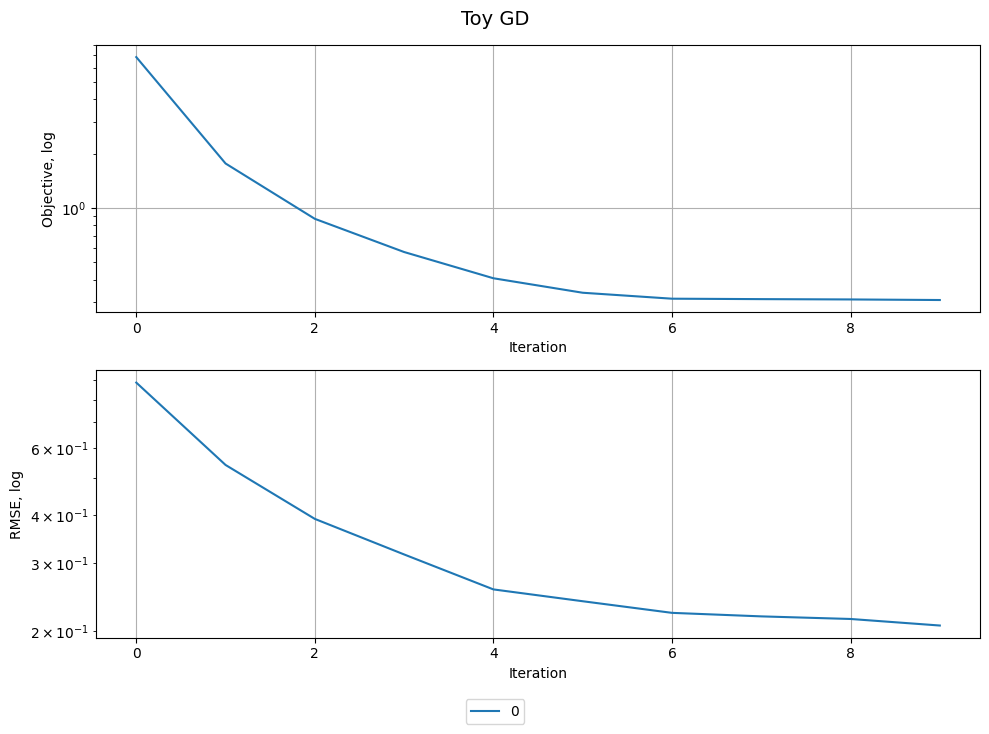

(tensor([[2.0000, 3.0000, 2.0000, 3.6263, 2.5018],
         [2.3818, 2.0000, 2.7281, 4.0000, 3.0000],
         [3.0000, 1.0262, 3.0000, 3.7778, 4.0000],
         [1.9959, 3.0000, 2.8371, 4.0000, 3.0000],
         [1.9153, 1.0000, 1.1414, 1.3626, 2.0000],
         [1.0000, 4.0000, 3.0000, 4.0000, 2.2055]], device='cuda:0'),
 0.20644183456897736,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'lr': 0.1,
  'optimizer': __main__.GradientDescent,
  'verbose': True,
  'regularization': 0,
  'lr_strategy': 'bisection'})

In [248]:
gd_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    block_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "lr": 1e-1,
        "optimizer": GradientDescent,
        "verbose": True,
        "regularization": 0,
        "lr_strategy": "bisection",
    },
)

plot_log_dicts(gd_toy_res[-1], "Toy GD")

gd_toy_res[:-1]

In [249]:
gd_bis_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 100,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 0,
        "clip": False,
        "lr": 1e-2,
        "lr_strategy": "bisection",
    },
)

plot_log_dicts(gd_bis_res[-1], "GD")

gd_bis_res[:-1]

 43%|████▎     | 217/500 [05:18<06:54,  1.47s/it, Objective=994, RMSE=0.772]    


KeyboardInterrupt: 

100%|██████████| 500/500 [00:23<00:00, 21.44it/s, Objective=1.02e+3, RMSE=0.783]


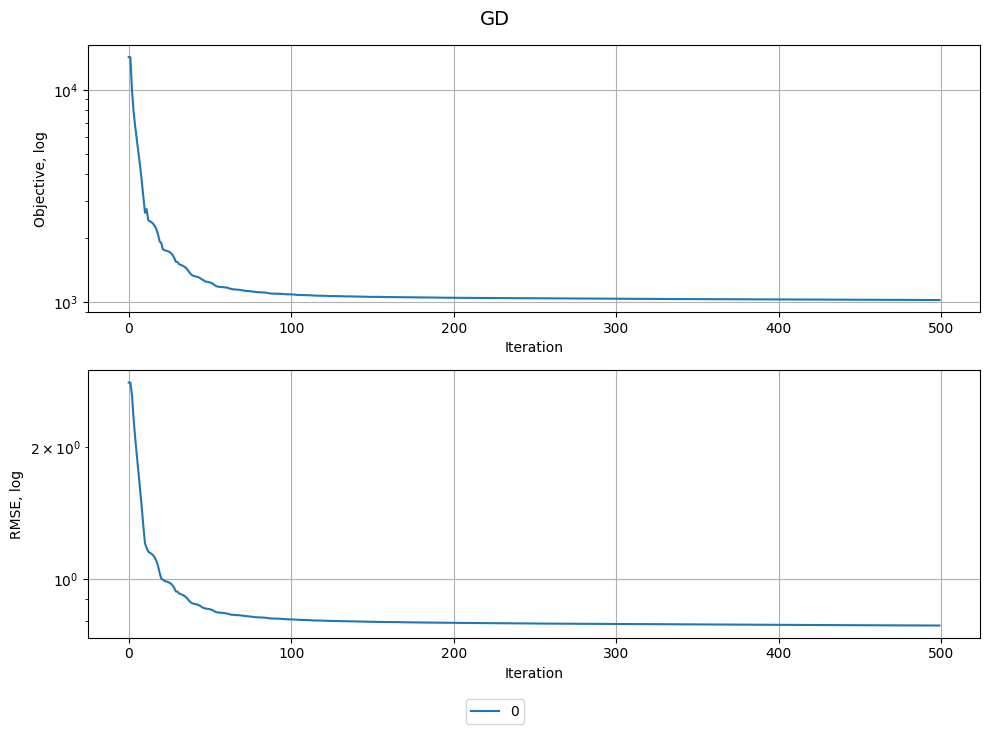

(tensor([[5.0000, 3.4585, 3.5412,  ..., 4.0094, 4.1453, 3.7912],
         [5.0000, 3.4648, 3.2727,  ..., 3.7709, 3.9197, 3.6940],
         [3.2053, 3.5383, 3.4801,  ..., 3.2019, 3.2998, 3.4913],
         ...,
         [2.4951, 1.4153, 1.7951,  ..., 3.7030, 4.1072, 4.0340],
         [3.8336, 3.5141, 3.0898,  ..., 3.5942, 3.8242, 3.9016],
         [3.0000, 1.5577, 1.2591,  ..., 3.6414, 4.0425, 3.6957]],
        device='cuda:0'),
 0.7828938364982605,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 1e-10,
  'lr_strategy': 'adaptive'})

In [250]:
gd_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 0,
        "clip": False,
        "lr": 1e-10,
        "lr_strategy": "adaptive",
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

100%|██████████| 500/500 [00:22<00:00, 22.24it/s, Objective=1.03e+3, RMSE=0.786]


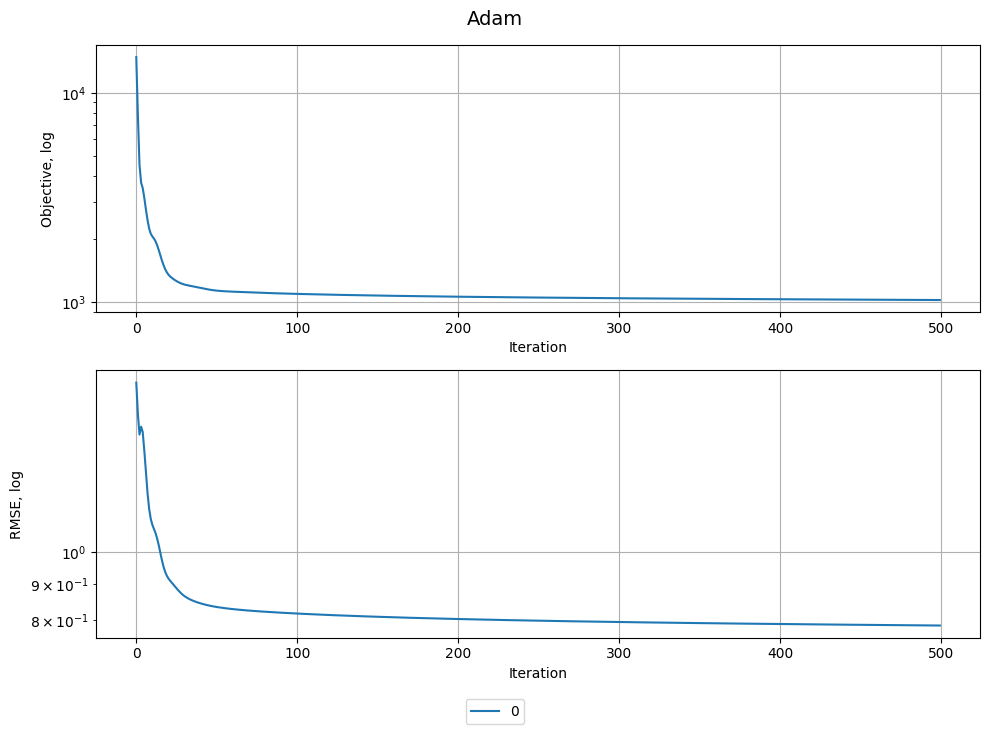

(tensor([[5.0000, 3.1929, 3.3701,  ..., 4.3445, 4.3499, 4.2615],
         [4.5133, 3.3975, 3.3220,  ..., 3.8189, 4.2680, 3.8040],
         [4.1247, 3.4418, 3.4285,  ..., 3.4851, 3.9074, 3.6681],
         ...,
         [3.8988, 3.1228, 2.7711,  ..., 3.5747, 4.3696, 3.2011],
         [3.9608, 3.1323, 2.7125,  ..., 3.7337, 4.2627, 3.8125],
         [3.0000, 1.9253, 1.1127,  ..., 2.7187, 3.5042, 3.2941]],
        device='cuda:0'),
 0.7856971621513367,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.Adam,
  'regularization': 0,
  'clip': False,
  'lr': <function __main__.<lambda>(k)>,
  'lr_strategy': 'normal'})

In [251]:
adam_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": Adam,
        "regularization": 0,
        "clip": False,
        "lr": lambda k: 1 / (k + 1),
        "lr_strategy": "normal",
    },
)

plot_log_dicts(adam_res[-1], "Adam")

adam_res[:-1]

100%|██████████| 500/500 [00:22<00:00, 22.46it/s, Objective=947, RMSE=0.752]    


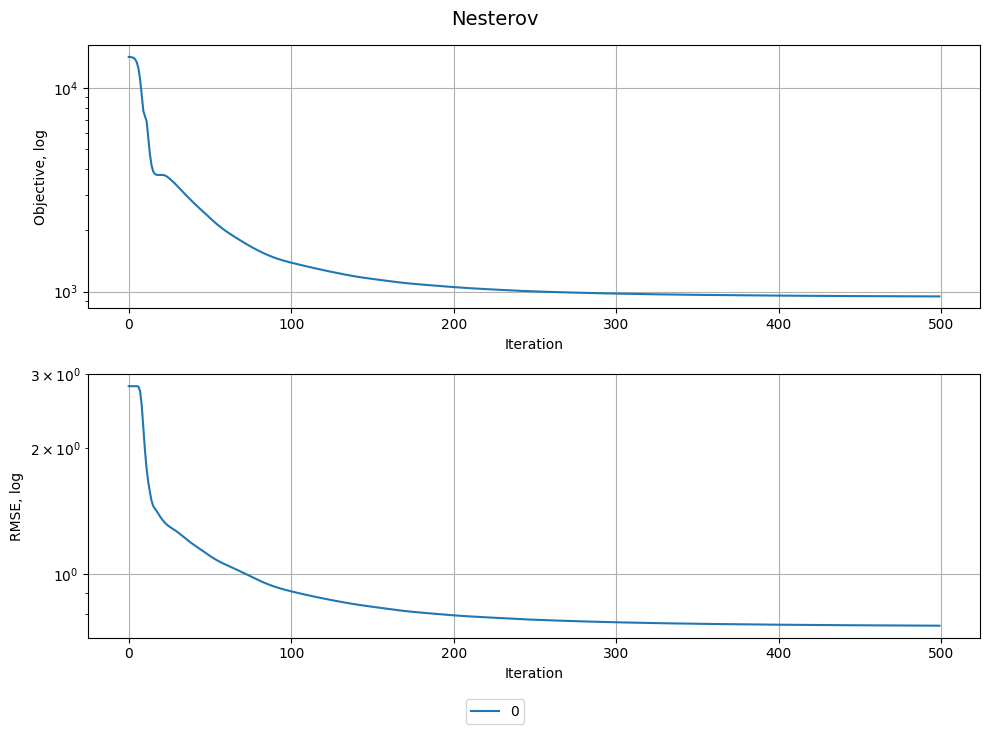

(tensor([[5.0000, 3.1462, 3.8318,  ..., 4.5901, 3.6992, 2.8810],
         [4.4591, 3.2764, 3.6037,  ..., 4.4820, 3.6310, 3.4438],
         [3.7143, 3.2406, 3.8366,  ..., 4.2006, 4.5671, 4.3036],
         ...,
         [3.9543, 3.7618, 2.8300,  ..., 3.6765, 5.0000, 5.0000],
         [3.8557, 3.2424, 2.9674,  ..., 3.6935, 4.1728, 4.1450],
         [3.0000, 1.7961, 1.0000,  ..., 2.8411, 3.9664, 3.8532]],
        device='cuda:0'),
 0.7516098022460938,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.Nesterov,
  'regularization': 0,
  'clip': False,
  'lr': <function __main__.<lambda>(k)>,
  'lr_strategy': 'normal'})

In [252]:
nesterov_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": Nesterov,
        "regularization": 0,
        "clip": False,
        "lr": lambda k: max(1e-4 / np.sqrt(k + 1), 1e-6),
        "lr_strategy": "normal",
    },
)

plot_log_dicts(nesterov_res[-1], "Nesterov")

nesterov_res[:-1]

100%|██████████| 500/500 [00:22<00:00, 22.19it/s, Objective=995, RMSE=0.771]    


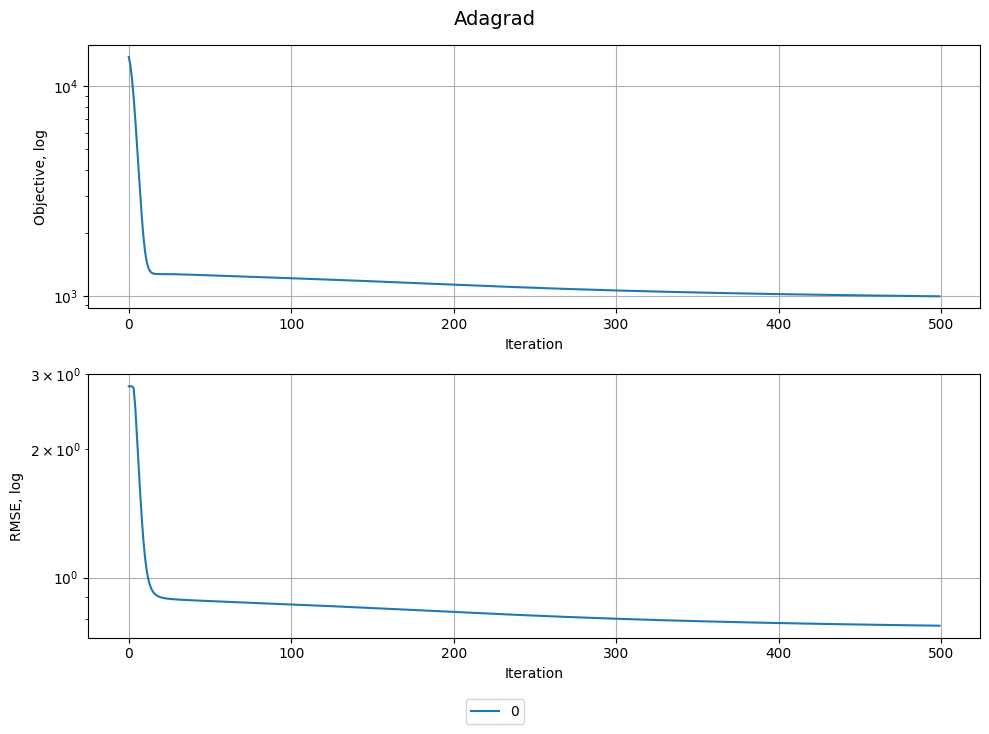

(tensor([[5.0000, 3.5446, 3.4686,  ..., 4.1742, 3.7632, 3.8837],
         [4.3625, 3.4599, 3.3585,  ..., 4.0687, 3.9349, 3.8234],
         [3.9981, 3.4573, 3.4496,  ..., 3.9607, 4.4620, 4.1660],
         ...,
         [3.2729, 2.9761, 2.5535,  ..., 3.3466, 5.0000, 4.1775],
         [4.0802, 3.2161, 2.7839,  ..., 3.4701, 4.0763, 3.8867],
         [3.0000, 2.2312, 1.4075,  ..., 3.1653, 4.5895, 3.4988]],
        device='cuda:0'),
 0.7708104252815247,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.AdaGrad,
  'regularization': 0,
  'clip': False,
  'lr': 0.1,
  'lr_strategy': 'normal'})

In [253]:
adagrad_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": AdaGrad,
        "regularization": 0,
        "clip": False,
        "lr": 1e-1,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(adagrad_res[-1], "Adagrad")

adagrad_res[:-1]

100%|██████████| 500/500 [00:22<00:00, 22.22it/s, Objective=981, RMSE=0.764]    


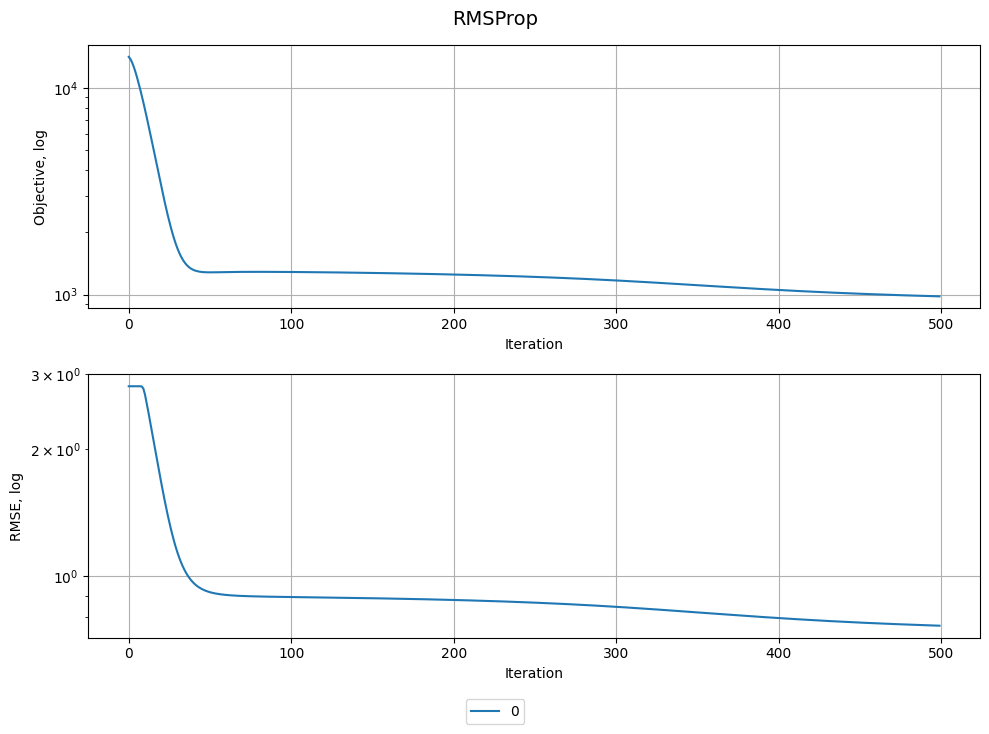

(tensor([[5.0000, 3.4363, 3.4609,  ..., 4.3125, 3.5866, 3.8052],
         [4.3853, 3.4296, 3.4196,  ..., 4.1805, 3.6592, 3.7448],
         [3.9169, 3.4716, 3.6026,  ..., 4.0585, 4.8992, 4.2208],
         ...,
         [3.2931, 3.1538, 2.5644,  ..., 3.3413, 5.0000, 4.3604],
         [4.0480, 3.2442, 2.8283,  ..., 3.5505, 4.0741, 3.9134],
         [3.0000, 2.2546, 1.3920,  ..., 3.0377, 4.6633, 3.5854]],
        device='cuda:0'),
 0.7644714117050171,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.RMSprop,
  'regularization': 0,
  'clip': False,
  'lr': 0.005,
  'lr_strategy': 'normal'})

In [254]:
rms_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": RMSprop,
        "regularization": 0,
        "clip": False,
        "lr": 5e-3,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(rms_res[-1], "RMSProp")

rms_res[:-1]

In [255]:
# save_solution(rms_res[0], decimals=5, prefix="rms_")

## Heuristic


In [256]:
# def clamp_to_mean(
#     result: torch.tensor, matrix: torch.tensor, mask: torch.tensor
# ) -> torch.tensor:
#     x = result.clone()

#     means = torch.sum(matrix, axis=0) / torch.sum(mask, axis=0)

#     for j, m in zip(range(x.shape[1]), means):
#         lower = torch.where(x[:, j] > m)[0]
#         upper = torch.where(x[:, j] <= m)[0]
#         x[lower, j] = torch.floor(x[lower, j]).float()
#         x[upper, j] = torch.ceil(x[upper, j]).float()

#     return matrix + (~mask) * x



In [257]:
# mean_res = clamp_to_mean(gd_res[0], real_matrix, real_mask)

In [258]:
# save_solution(mean_res, decimals=0, prefix="gdeur")

In [259]:
# save_solution(torch.round(gd_res[0]), decimals=0, prefix="gderound")